In [1]:
import argparse
import gc
import hashlib
import itertools
import logging
import math
import os
import threading
import warnings
from pathlib import Path
from typing import Optional
import psutil
import json

import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset

import datasets
import diffusers
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import DDPMScheduler, PNDMScheduler, StableDiffusionPipeline
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from diffusers.optimization import get_scheduler
from diffusers.utils import check_min_version
from diffusers.utils.import_utils import is_xformers_available
from huggingface_hub import HfFolder, Repository, whoami
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import AutoTokenizer, PretrainedConfig, CLIPFeatureExtractor
from peft import PeftModel, LoraConfig, get_peft_model_state_dict, set_peft_model_state_dict

# Will error if the minimal version of diffusers is not installed. Remove at your own risks.
check_min_version("0.10.0.dev0")

logger = get_logger(__name__)


MODEL_NAME = "CompVis/stable-diffusion-v1-4"  # "stabilityai/stable-diffusion-2-1-base"
INSTANCE_PROMPT = "mumbattan"
base_path = "/home/huram-abi/CS236_Project/"

2023-12-06 07:01:59.816675: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
For effortless bug reporting copy-paste your error into this form: https://docs.google.com/forms/d/e/1FAIpQLScPB8emS3Thkp66nvqwmjTEgxp8Y9ufuWTzFyr9kJ5AoI47dQ/viewform?usp=sf_link
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 113
CUDA SETUP: Loading binary /opt/conda/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda113.so...


/opt/conda/lib/python3.10/site-packages/bitsandbytes/cuda_setup/paths.py:93: UserWarning: /opt/conda did not contain libcudart.so as expected! Searching further paths...
  warn(


In [2]:
def get_lora_sd_pipeline(
    ckpt_dir, base_model_name_or_path=None, dtype=torch.float16, device="cuda", adapter_name="default"
):
    unet_sub_dir = os.path.join(ckpt_dir, "unet")
    text_encoder_sub_dir = os.path.join(ckpt_dir, "text_encoder")
    if os.path.exists(text_encoder_sub_dir) and base_model_name_or_path is None:
        config = LoraConfig.from_pretrained(text_encoder_sub_dir)
        base_model_name_or_path = config.base_model_name_or_path

    if base_model_name_or_path is None:
        raise ValueError("Please specify the base model name or path")

    pipe = StableDiffusionPipeline.from_pretrained(
        base_model_name_or_path, torch_dtype=dtype, requires_safety_checker=False
    ).to(device)
    pipe.unet = PeftModel.from_pretrained(pipe.unet, unet_sub_dir, adapter_name=adapter_name)

    if os.path.exists(text_encoder_sub_dir):
        pipe.text_encoder = PeftModel.from_pretrained(
            pipe.text_encoder, text_encoder_sub_dir, adapter_name=adapter_name
        )

    if dtype in (torch.float16, torch.bfloat16):
        pipe.unet.half()
        pipe.text_encoder.half()

    pipe.to(device)
    return pipe


def load_adapter(pipe, ckpt_dir, adapter_name):
    unet_sub_dir = os.path.join(ckpt_dir, "unet")
    text_encoder_sub_dir = os.path.join(ckpt_dir, "text_encoder")
    pipe.unet.load_adapter(unet_sub_dir, adapter_name=adapter_name)
    if os.path.exists(text_encoder_sub_dir):
        pipe.text_encoder.load_adapter(text_encoder_sub_dir, adapter_name=adapter_name)


def set_adapter(pipe, adapter_name):
    pipe.unet.set_adapter(adapter_name)
    if isinstance(pipe.text_encoder, PeftModel):
        pipe.text_encoder.set_adapter(adapter_name)


def merging_lora_with_base(pipe, ckpt_dir, adapter_name="default"):
    unet_sub_dir = os.path.join(ckpt_dir, "unet")
    text_encoder_sub_dir = os.path.join(ckpt_dir, "text_encoder")
    if isinstance(pipe.unet, PeftModel):
        pipe.unet.set_adapter(adapter_name)
    else:
        pipe.unet = PeftModel.from_pretrained(pipe.unet, unet_sub_dir, adapter_name=adapter_name)
    pipe.unet = pipe.unet.merge_and_unload()

    if os.path.exists(text_encoder_sub_dir):
        if isinstance(pipe.text_encoder, PeftModel):
            pipe.text_encoder.set_adapter(adapter_name)
        else:
            pipe.text_encoder = PeftModel.from_pretrained(
                pipe.text_encoder, text_encoder_sub_dir, adapter_name=adapter_name
            )
        pipe.text_encoder = pipe.text_encoder.merge_and_unload()

    return pipe


def create_weighted_lora_adapter(pipe, adapters, weights, adapter_name="default"):
    pipe.unet.add_weighted_adapter(adapters, weights, adapter_name)
    if isinstance(pipe.text_encoder, PeftModel):
        pipe.text_encoder.add_weighted_adapter(adapters, weights, adapter_name)

    return pipe

In [24]:
%%time
pipe = get_lora_sd_pipeline(os.path.join(base_path, "Earth-50101B"), adapter_name="Earth-X")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


CPU times: user 6.06 s, sys: 1.61 s, total: 7.66 s
Wall time: 3.29 s


  0%|          | 0/50 [00:00<?, ?it/s]

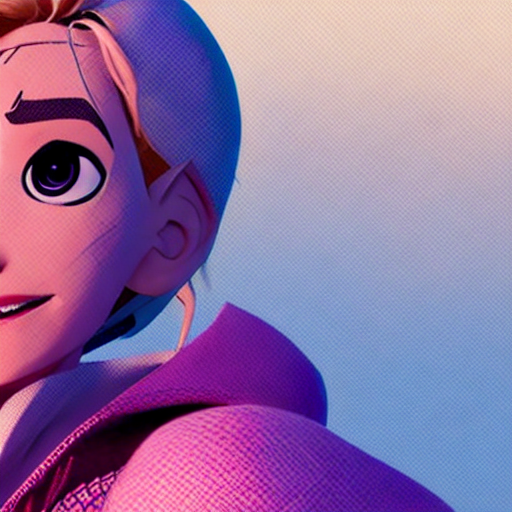

In [9]:
prompt = "a photo of gwen in the spiderverse "
negative_prompt = "good quality, clear , finished"
image = pipe(prompt, num_inference_steps=50, guidance_scale=7, negative_prompt=negative_prompt).images[0] 
image

In [25]:
%%time
load_adapter(pipe, os.path.join(base_path, "Person_model"), adapter_name="spiderman")

CPU times: user 142 ms, sys: 87 µs, total: 143 ms
Wall time: 141 ms


In [28]:
pipe = create_weighted_lora_adapter(pipe, ["Earth-X", "spiderman"], [3,10.0], adapter_name="Earth-X-Spiderman")

In [29]:
%%time
set_adapter(pipe, adapter_name="Earth-X-Spiderman")

CPU times: user 13.2 ms, sys: 54 µs, total: 13.3 ms
Wall time: 12.9 ms


In [10]:
!ls ~/

CS236_Project  hw2_handout  hw3_handout


In [3]:
prompt = "World of Earth-50101B"
negative_prompt = "good quality, clear , finished"


In [30]:
%%time
for i in range(10):
    prompt = "spiderman on Earth-50101B"
    negative_prompt = "good quality, clear , finished"
    image = pipe(prompt, num_inference_steps=50, guidance_scale=7, negative_prompt=negative_prompt).images[0] # fine tuned
    image.save(f"spder/f/FToutput{i}.png")

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 1min 49s, sys: 609 ms, total: 1min 49s
Wall time: 1min 43s


In [31]:
pipe2 = StableDiffusionPipeline.from_pretrained(MODEL_NAME, torch_dtype=torch.float16).to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [20]:
from transformers import AutoTokenizer, PretrainedConfig

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME,
                                          subfolder="tokenizer",
                                          use_fast=True,)

tokens =tokenizer("mumbattan",
          truncation=True,
          padding="max_length",
          max_length=tokenizer.model_max_length,
          return_tensors="pt",
        )

In [21]:
tokens.tokens(batch_index=0)

['<|startoftext|>',
 'mumb',
 'att',
 'an</w>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>',
 '<|endoftext|>'

In [ ]:
tokens.data

In [ ]:
dir(tokens)

In [ ]:
image = pipe2(prompt, num_inference_steps=50, guidance_scale=7, negative_prompt=negative_prompt).images[0]
image

In [32]:
for i in range(10):
    prompt = "spiderman on Earth-50101B"
    negative_prompt = "good quality, clear , finished"
    image = pipe2(prompt, num_inference_steps=50, guidance_scale=7, negative_prompt=negative_prompt).images[0] # Not Finetuned
    image.save(f"EX/fake/no_FToutput{i}.png")

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
image.images[0]

In [ ]:
%%time
set_adapter(pipe, adapter_name="toy")

In [ ]:
prompt = "narendra modi rendered in the style of <1>"
negative_prompt = "low quality, blurry, unfinished"
image = pipe(prompt, num_inference_steps=50, guidance_scale=7, negative_prompt=negative_prompt).images[0]
image

  0%|          | 0/50 [00:00<?, ?it/s]

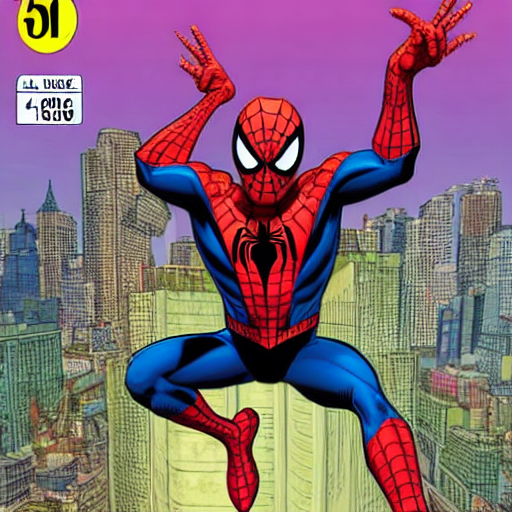

In [32]:
set_adapter(pipe, adapter_name="Earth-X")
prompt = "spiderman on Earth-50101b"
negative_prompt = "low quality, blurry, unfinished"
image = pipe(prompt, num_inference_steps=50, guidance_scale=7, negative_prompt=negative_prompt).images[0]
image

  0%|          | 0/50 [00:00<?, ?it/s]

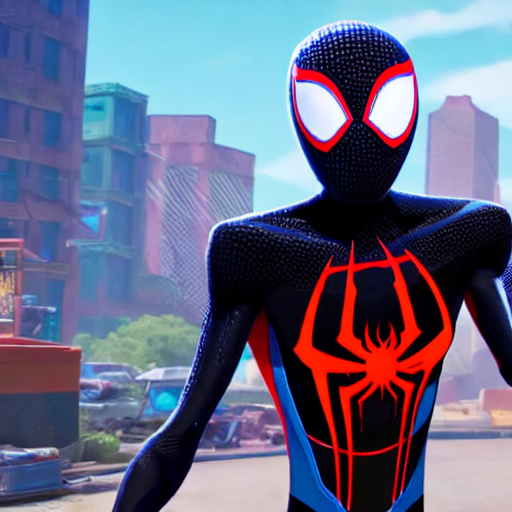

In [24]:
set_adapter(pipe, adapter_name="spiderman")
prompt = "spiderman on Earth-50101b"
negative_prompt = "low quality, blurry, unfinished"
image = pipe(prompt, num_inference_steps=50, guidance_scale=7, negative_prompt=negative_prompt).images[0]
image

  0%|          | 0/50 [00:00<?, ?it/s]

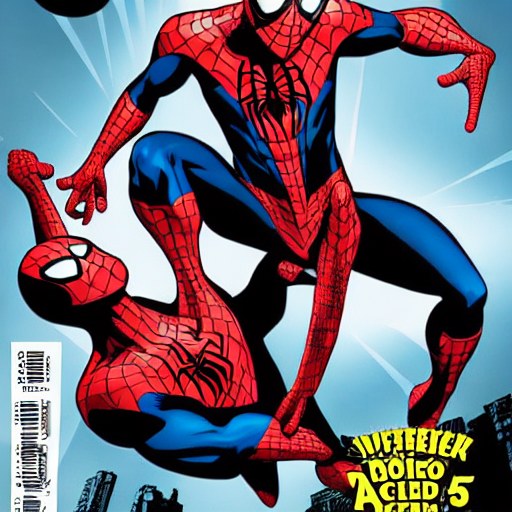

In [33]:
set_adapter(pipe, adapter_name="Earth-X-Spiderman")
prompt = "spiderman on Earth-50101b"
negative_prompt = "low quality, blurry, unfinished"
image = pipe(prompt, num_inference_steps=50, guidance_scale=7, negative_prompt=negative_prompt).images[0]
image

In [ ]:
%tensorboard --logdir /home/huram-abi/CS236_Project/DreamBooth_Output/logs/dreambooth

In [16]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torchmetrics.image.kid import KernelInceptionDistance

In [17]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

def get_features(images, model, transform):
    features = []
    for img in images:
        img = transform(img).unsqueeze(0)
        with torch.no_grad():
            pred = model(img)
        features.append(pred.cpu().numpy().flatten())
    return np.array(features)

In [ ]:
torch.tensor(load_images_from_folder("/home/huram-abi/CS236_Project/peft/examples/lora_dreambooth/images_r/spiderverse_10"))

In [35]:


def load_dataset(directory, transform):
    dataset = ImageFolder(directory, transform=transform)
    return DataLoader(dataset, batch_size=10, shuffle=False)

# Define the transformations
transform = transforms.Compose([
    transforms.PILToTensor(),
])

# Load datasets
real_images_directory = '/home/huram-abi/CS236_Project/Spiderman_mumbattan_mask'
fake_images_directory = '/home/huram-abi/CS236_Project/peft/examples/lora_dreambooth/EX'
real_loader = load_dataset(real_images_directory, transform)
fake_loader = load_dataset(fake_images_directory, transform)


# Initialize KID
kid = KernelInceptionDistance(subset_size=10)

a = list(iter(real_loader.dataset))
b = list(iter(fake_loader.dataset))
# Assuming each loader contains only one batch of 10 images
real_features = torch.reshape(torch.cat([p[0] for p in a]), (10,3,800,-1))
fake_features = torch.reshape(torch.cat([p[0] for p in b]), (10,3,512,-1))




In [ ]:
fake_features.shape

In [ ]:
a = list(iter(real_loader.dataset))

l = [p[0] for p in a]


In [ ]:
# help(kid)

In [36]:
# Update KID with features from real and fake images
kid.update(real_features, real=True)
kid.update(fake_features, real=False)

# Compute KID
kid_score = kid.compute()
print("KID Score:", kid_score)

KID Score: (tensor(0.3116), tensor(1.4757e-07))
